In [ ]:
import grain
from tqdm import tqdm
import os
import pickle
from transformers import AutoTokenizer
import numpy as np
import jax
import time
from datasets import load_dataset
import matplotlib.pyplot as plt

/Users/jack/projects/jaximus/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
sequence_length = 1024
batch_size = 64

(100000, 13)

In [3]:
class ParseArrayRecord(grain.transforms.Map):
  def map(self, x):
    return pickle.loads(x)

class Tokenize(grain.transforms.Map):
  def __init__(self, tokenizer, prepend_bos=True):
    self.prepend_bos = prepend_bos
    self.tokenizer = tokenizer

  def map(self, x):
    tokens = self.tokenizer.encode(x["text"])
    if self.prepend_bos:
      return {"tokens": np.asarray([self.tokenizer.bos_token_id] + tokens, dtype=np.int32)}
    else:
      return {"tokens": np.asarray(tokens, dtype=np.int32)}

class Trim(grain.transforms.Map):
  def __init__(self, max_length):
    self.max_length = max_length

  def map(self, x):
    return {"tokens": x["tokens"][:self.max_length]}
  
class Shift(grain.transforms.Map):
  def map(self, x):
    return (x["tokens"][:-1], x["tokens"][1:])

In [4]:
def get_array_record_dataset(
    path,
    sequence_length,
    batch_size,
    tokenizer=None,
):

    array_files = os.listdir(path)
    array_files = [f"{path}/{f}" for f in array_files if f.endswith(".array_record")]

    
    ds = (
        grain.MapDataset.source(grain.sources.ArrayRecordDataSource(array_files))
        .map(ParseArrayRecord())
    )

    # if no tokenizer, assume already tokenized
    if tokenizer:
        ds = ds.map(Tokenize(tokenizer, prepend_bos=True))

    # shard the dataset
    ds = ds[jax.process_index()::jax.process_count()]

    ds = grain.experimental.ConcatThenSplitIterDataset(
        parent=ds,
        length_struct={"tokens": sequence_length + 1},
    )

    assert batch_size % jax.process_count() == 0, "batch_size must be divisible by process_count"


    local_batch_size = batch_size // jax.process_count()
    ds = ds.map(Shift()).batch(local_batch_size, drop_remainder=True)

    return ds

In [5]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
dataset = get_array_record_dataset(
    path="/Users/jack/projects/jaximus/saved/fineweb_sample_10BT",
    sequence_length=sequence_length,
    batch_size=batch_size,
    tokenizer=tokenizer,
)

In [6]:
dataset_iter = iter(dataset)

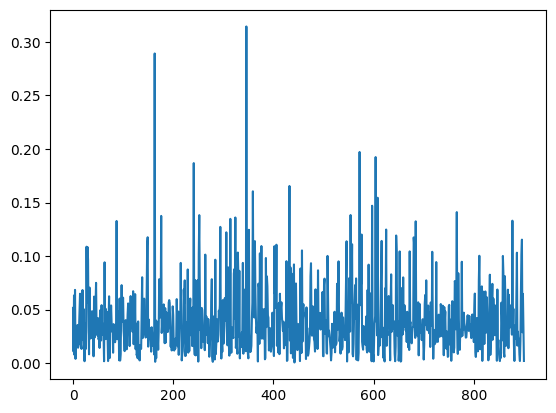

In [8]:
atimes = []
t0 = time.time()
for idx, (x, y) in enumerate(dataset_iter):
   z = x + y
   if idx > 1000:
      break
   atimes.append(time.time() - t0)
   t0 = time.time()
plt.plot(atimes[100:])

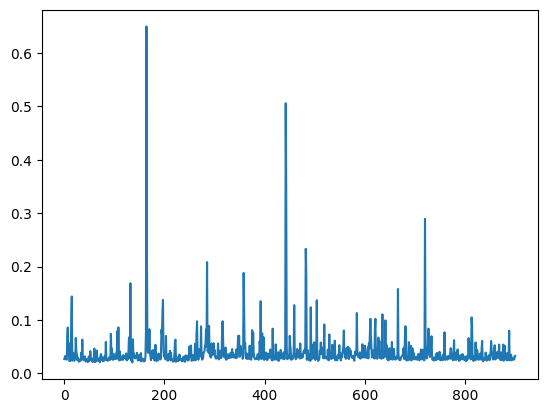

In [9]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
dataset = get_array_record_dataset(
    path="/Users/jack/projects/jaximus/saved/fineweb_sample_10BT_tokenized",
    sequence_length=sequence_length,
    batch_size=batch_size,
    # tokenizer=tokenizer,
)

dataset_iter = iter(dataset)

dtimes = []
t0 = time.time()
for idx, (x, y) in enumerate(dataset_iter):
   z = x + y
   if idx > 1000:
      break
   dtimes.append(time.time() - t0)
   t0 = time.time()
plt.plot(dtimes[100:])

In [10]:
from datasets import load_dataset

In [11]:
class HFStreamingDataSource(grain.sources.RandomAccessDataSource):
    def __init__(self, iterable_ds):
        self._ds = iterable_ds
        self._it = None

    def __len__(self) -> int:
        return 10_000_000_000

    def __getitem__(self, record_key: int):
        if self._it is None:
            self._it = iter(self._ds)
        try:
            return next(self._it)
        except StopIteration:
            self._it = iter(self._ds)
            return next(self._it)


def get_hf_dataset(
    hf_name,
    sequence_length,
    batch_size,
    tokenizer=None,
    streaming=True,
    num_proc=None,
):

    hf_ds = (
        load_dataset(*hf_name, split="train", streaming=streaming, num_proc=num_proc)
        .shard(
            num_shards=jax.process_count(), 
            index=jax.process_index()
        )
    )

    source = HFStreamingDataSource(hf_ds) if streaming else hf_ds 
    ds = (
        grain.MapDataset.source(source)
        .to_iter_dataset(read_options=grain.ReadOptions(num_threads=1 if streaming else 16))
    )

    # if no tokenizer, assume already tokenized
    if tokenizer:
        ds = ds.map(Tokenize(tokenizer, prepend_bos=True))

    ds = grain.experimental.ConcatThenSplitIterDataset(
        parent=ds,
        length_struct={"tokens": sequence_length + 1},
    )

    assert batch_size % jax.process_count() == 0, "batch_size must be divisible by process_count"

    local_batch_size = batch_size // jax.process_count()
    ds = ds.map(Shift()).batch(local_batch_size, drop_remainder=True)

    return ds

In [12]:
hf_dataset = get_hf_dataset(
    hf_name=["HuggingFaceFW/fineweb-edu", "sample-10BT"],
    sequence_length=sequence_length,
    batch_size=batch_size,
    tokenizer=tokenizer,
    streaming=True,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [13]:
hf_iter = iter(hf_dataset)

Token indices sequence length is longer than the specified maximum sequence length for this model (1055 > 1024). Running this sequence through the model will result in indexing errors


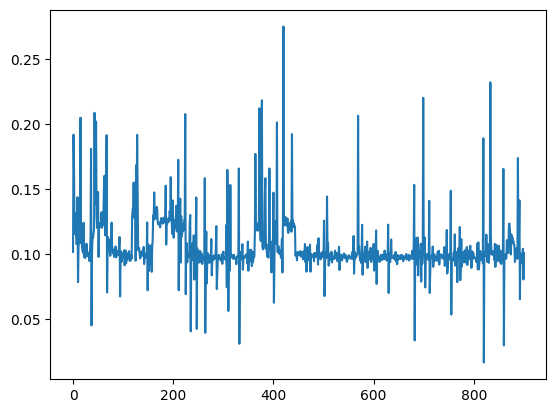

In [14]:
btimes = []
t0 = time.time()
for idx, (x, y) in enumerate(hf_iter):
   z = x + y
   if idx > 1000:
      break
   btimes.append(time.time() - t0)
   t0 = time.time()
plt.plot(btimes[100:])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

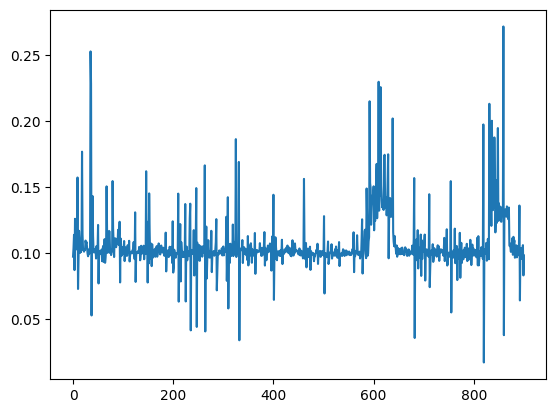

In [15]:
hf_dataset = get_hf_dataset(
    hf_name=["HuggingFaceFW/fineweb-edu", "sample-10BT"],
    sequence_length=sequence_length,
    batch_size=batch_size,
    tokenizer=tokenizer,
    streaming=False,
    num_proc=6,
)

hf_iter = iter(hf_dataset)

ctimes = []
t0 = time.time()
for idx, (x, y) in enumerate(hf_iter):
   z = x + y
   if idx > 1000:
      break
   ctimes.append(time.time() - t0)
   t0 = time.time()
plt.plot(ctimes[100:])

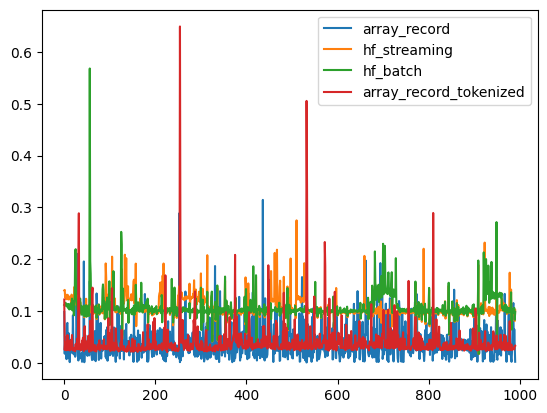

In [16]:
plt.plot(atimes[10:])
plt.plot(btimes[10:])
plt.plot(ctimes[10:])
plt.plot(dtimes[10:])
plt.legend(["array_record", "hf_streaming", "hf_batch", "array_record_tokenized"])
plt.show()

In [19]:
# add p99
print("array_record", np.mean(atimes[100:]), np.std(atimes[100:]), np.min(atimes[100:]), np.max(atimes[100:]), np.percentile(atimes[100:], 99), np.percentile(atimes[100:], 95))
print("hf_streaming", np.mean(btimes[100:]), np.std(btimes[100:]), np.min(btimes[100:]), np.max(btimes[100:]), np.percentile(btimes[100:], 99), np.percentile(btimes[100:], 95))
print("hf_batch", np.mean(ctimes[100:]), np.std(ctimes[100:]), np.min(ctimes[100:]), np.max(ctimes[100:]), np.percentile(ctimes[100:], 99), np.percentile(ctimes[100:], 95))
print("array_record_tokenized", np.mean(dtimes[100:]), np.std(dtimes[100:]), np.min(dtimes[100:]), np.max(dtimes[100:]), np.percentile(dtimes[100:], 99), np.percentile(dtimes[100:], 95))

array_record 0.03981265508374417 0.032404518525471875 0.0005710124969482422 0.31441593170166016 0.14102411270141602 0.10309815406799316
hf_streaming 0.10607912352558775 0.02206929507915375 0.016885042190551758 0.2749183177947998 0.20193791389465332 0.14380693435668945
hf_batch 0.10641923278867868 0.02139285350155391 0.017175912857055664 0.271589994430542 0.20018887519836426 0.14404916763305664
array_record_tokenized 0.039649889286562025 0.03619616526463303 0.020540952682495117 0.6492321491241455 0.1687910556793213 0.0796658992767334
